# Spacecraft Pose Estimation Model Example

In [1]:
%matplotlib inline
USE_GPU = True

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from random import randint
from dataloader_utils import *
torch.manual_seed(42)
from PIL import Image, ImageDraw
from matplotlib import cm
import torchvision.transforms.functional as tF
from vp_loss import SoftmaxVPLoss
from metrics import *

if USE_GPU:
    print(torch.cuda.is_available())

True


## Testing dataloader

In [3]:
dataset_root_dir = '../../speed'
annotations_root_dir = '../annotations'

sample_transform = transforms.Compose([
    transforms.RandomRotation((-30, 30))
])

sample_dataset = SpeedDataset(speed_root=dataset_root_dir, annotations_root=annotations_root_dir, transform=None)

Bounding box [x_min, y_min, x_max, y_max]: [571.89217841 547.14270504 901.62193347 509.08239738]


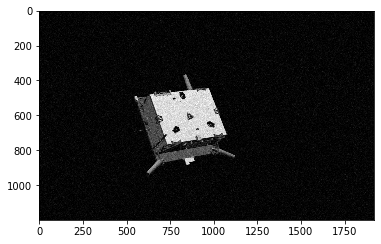

In [4]:
i = 895
img, label, K = sample_dataset[i]
plt.figure()
plt.imshow(img)
print("Bounding box [x_min, y_min, x_max, y_max]: {}".format(label[-4:]))

## Dataloading

In [5]:
class JointRescrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, target):
        target_q = target[:4]
        target_r = target[4:7]
        target_db = target[7:11] 
        target_bb = target[11:]

        sz = self.size[0]
        # Determine crop size that will still capture entire satellite
        x = [target_bb[i] for i in range(0, len(target_bb), 2)]
        y = [target_bb[i] for i in range(1, len(target_bb), 2)]
        xmin = min(x); xmax = max(x)
        ymin = min(y); ymax = max(y)
        fS = 1.75
        dx = xmax - xmin
        dy = ymax - ymin
        self.cropSize = int(fS * max(dx, dy))
        if self.cropSize > min(img.size):
            self.cropSize = min(img.size)
#         print("cropSize: ", cropSize)
        
        # Crop Image
        self.cx = sum(x)/len(x)
        self.cy = sum(y)/len(y)
        top = self.cy - self.cropSize/2
        left = self.cx - self.cropSize/2
        img = tF.crop(img, top, left, self.cropSize, self.cropSize)
        
        # Crop translation of points
        xtarget = [self.cropSize/2 + (i - self.cx) for i in x]
        ytarget = [self.cropSize/2 + (i - self.cy) for i in y]
        target_bb = [None]*(len(xtarget)+len(ytarget))
        target_bb[::2] = xtarget
        target_bb[1::2] = ytarget
        target_bb = np.array(target_bb)
        
        # Rescale to input size
        norm = img.size[1]
        img = tF.resize(img, sz)
        target_bb = [sz * i / norm for i in target_bb]

        # Update db from bb
        xa = target_bb[0::2]
        ya = target_bb[1::2]
        target_db = [min(xa), min(ya), max(xa), max(ya)]
        
        target = np.concatenate((target_q, target_r, target_db, target_bb))

        return img, target

In [6]:
class JointToTensor(object):
    def __call__(self, img, target):
        return tF.to_tensor(img), torch.from_numpy(target)

In [7]:
class JointCompose(object):
    def __init__(self, transforms):
        """
        params: 
           transforms (list) : list of transforms
        """
        self.transforms = transforms

    # We override the __call__ function such that this class can be
    # called as a function i.e. JointCompose(transforms)(img, target)
    # Such classes are known as "functors"
    def __call__(self, img, target):
        """
        params:
            img (PIL.Image)    : input image
            target (PIL.Image) : ground truth label 
        """
        for t in self.transforms:
            img, target = t(img, target)
        return img, target

In [8]:
class JointNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, img, target):
        # Expects img to be a tensor
        timg = tF.normalize(img, self.mean, self.std)
        return (timg, target)

In [9]:
# Transforms
train_transform = JointCompose([
    JointRescrop((256,256)),
    JointToTensor(),
#     JointNormalize([0.5], [0.5])
])

sanity_transform = JointCompose([
    JointRescrop((256,256)),
    JointToTensor(),
])

In [10]:
# Datasets
# NOTE: we don't have the labels for the test set, so we need to split the training set
training_dataset = SpeedDataset(
    split="train",
    split_index=1000, # used to make a smaller training set for dev
    speed_root=dataset_root_dir,
    annotations_root=annotations_root_dir,        
    transform=train_transform
)

sanity_dataset = SpeedDataset(
    split="train",
    sanity_check=100,
    speed_root=dataset_root_dir,
    annotations_root=annotations_root_dir,        
    transform=sanity_transform
)

[129.39001083162302, 106.49745510471199]

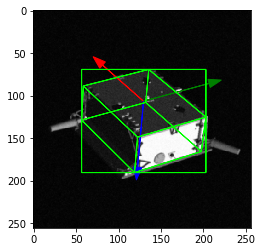

In [11]:
# TEST
sample, target, K = training_dataset[17]
sample2, target2, K2 = training_dataset[80]
image1, label1 = JointRescrop((256, 256))(tF.to_pil_image(sample), target.numpy())
image2, label2 = JointRescrop((256, 256))(tF.to_pil_image(sample2), target2.numpy())
training_dataset.visualize(image2, label2, K2, factor=0.6, bbox=True, dbox=True)

In [12]:
(train_len, test_len) = (int(0.85*len(training_dataset)), int(0.15*len(training_dataset)))
assert train_len + test_len == len(training_dataset)
train_dataset, test_dataset = torch.utils.data.random_split(training_dataset, (train_len, test_len))

In [13]:
# Dataloading
WORKERS=6
train_loader = DataLoader(train_dataset, batch_size=16, num_workers=WORKERS, shuffle=False, drop_last=True) # NOTE: set shuffle to True!
sanity_loader = DataLoader(sanity_dataset, batch_size=1, num_workers=WORKERS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=WORKERS, shuffle=False, drop_last=True)

## Network implementations
The following is an end-to-end implementation based on [USRO](https://arxiv.org/pdf/1907.04298.pdf) which seeks simplicity over efficiency. The team finished in 3rd place using resnet101 as their backbone. This implementation relies on resnet34 instead for computational reasons.

Mango performs direct regression of both translation and orientation (quaternions and EA are used). A 2D bounding box is used to contrain the regression of the translation (donkey tail analogy). Considering it is only doing regression, Mango's results are pretty good, but not great. There's evidence that what the network learned generalizes poorly to certain orientations of the satellite. The Mango implementation serves as our **baseline**.

Tango still regresses the translation but learns the correct orientation via classification (based on the discretization of the domain of each Euler angle). Tango is more **experimental**.

In [14]:
# Pre-trained layers
resnet = models.resnet34(pretrained=True)

In [15]:
class MangoNet(nn.Module):
    def __init__(self, criterion=None):
        super(MangoNet, self).__init__()

        # Resnet backbone
        self.resnet = nn.Sequential(*list(resnet.children())[:-2]) 
        self.conv6 = nn.Conv2d(512, 1024, 3, 2)
        self.bn1 = nn.BatchNorm2d(1024)
        
        # Translation branch: t = [tx, ty, tz]
#         self.fc_t1 = nn.Linear(3*3*1024, 1024)
#         self.fc_t2 = nn.Linear(1024, 3)
        self.t_branch = nn.Sequential(nn.Linear(3*3*1024, 1024),
                                      nn.ReLU(inplace=True),
                                      nn.Dropout(),
                                      nn.Linear(1024, 3))



        # Attitude branch: q = [q0, q1, q2, q3]
#         self.fc_att1 = nn.Linear(3*3*1024, 1024)
#         self.fc_att2 = nn.Linear(1024, 4) # unit-quaternions
#         #self.fc_att2 = nn.Linear(1024, 3) # MRP
        self.att_branch = nn.Sequential(nn.Linear(3*3*1024, 1024),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(),
                                        nn.Linear(1024, 4),
                                        nn.Tanh())
    
    def forward(self, input, gt=None):
        # Input size: 256x256
        # x = F.relu(self.resnet(input)) # NOTE: should we add activation after resnet?
        x = self.resnet(input)
        x = F.relu(self.bn1(self.conv6(x)))
        # Reshape after bottleneck
        x_t = x.view(-1, 3*3*1024)
        x_att = x.view(-1, 3*3*1024)

        # T regression
#         x_t = F.relu(self.fc_t1(x_t))
#         x_t = self.fc_t2(x_t)
        x_t = self.t_branch(x_t)

        # q regression
#         x_att = F.relu(self.fc_att1(x_att))
#         x_att = torch.tanh(self.fc_att2(x_att))
        x_att = self.att_branch(x_att)


        return x_t, x_att
        # return x_att


In [16]:
class TangoNet(nn.Module):
    def __init__(self, criterion=None):
        super(TangoNet, self).__init__()

        # Resnet backbone
        self.resnet = nn.Sequential(*list(resnet.children())[:-2]) 
        self.conv6 = nn.Conv2d(512, 1024, 3, 2)
        self.bn1 = nn.BatchNorm2d(1024)
        
        # Translation branch: t = [tx, ty, tz]
        self.fc_t1 = nn.Linear(3*3*1024, 1024)
        self.fc_t2 = nn.Linear(1024, 3)

        # Attitude branch: classification: 360 discrete EA bins
        self.fc_att1 = nn.Linear(3*3*1024, 4096)
        self.drop = nn.Dropout(p=0.5)
        
        self.infer = nn.Sequential( 
                    nn.Linear(9216,4096),
                    nn.ReLU(),
#                     nn.Dropout(0.5),
                    nn.Linear(4096,4096),
#                     nn.Linear(4096,1024),
                    nn.ReLU(),
#                     nn.Dropout(0.5),
                    )

            
            
        self.th1 = nn.Linear(4096, 360)
        self.th2 = nn.Linear(4096, 360)
        self.th3 = nn.Linear(4096, 360)
    
    def forward(self, input, gt=None):
        # Input size: 256x256
        x = self.resnet(input)
        x = F.relu(self.bn1(self.conv6(x)))
        # Reshape after bottleneck
        # x_t = x.view(-1, 3*3*1024)
        x_att = x.view(-1, 3*3*1024)

        x_att = self.infer(x_att)

        # T regression
        # x_t = F.relu(self.fc_t1(x_t))
        # x_t = self.fc_t2(x_t)

        # q regression
#         x_att = F.relu(self.fc_att1(x_att))
#         x_att = self.drop(x_att)
        th1 = self.th1(x_att)
        th2 = self.th2(x_att)
        th3 = self.th3(x_att)        

        return th1, th2, th3
        # return x_t, th1, th2, th3


### Training

In [17]:
OVERFIT=False
TRAINING=True
BETA=1
if OVERFIT:
    overfit_net = TangoNet()
    if USE_GPU:
        overfit_net = overfit_net.cuda()

In [18]:
def get_of_optimizer(net):
#     optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=0.0003,
                                weight_decay=0.001,
                                momentum=0.9)
    return optimizer

In [19]:
def q_to_mrp(q):
    return q[1:4] / (1 + q[0])

In [20]:
def dcm_to_q(dcm):
    q0 = -0.5*np.sqrt(dcm[0][0]+dcm[1][1]+dcm[2][2]+1)
    q1 = (dcm[1][2]-dcm[2][1])/(4*q0)
    q2 = (dcm[2][0]-dcm[0][2])/(4*q0)
    q3 = (dcm[0][1]-dcm[1][0])/(4*q0)

    return [q0, q1, q2, q3]

In [21]:
def mrp_to_q(sigma):
    s2 = np.dot(sigma.T, sigma)
    q0 = (1-s2)/(1+s2)
    qi = 2*sigma/(1+s2)
    return np.concatenate((np.array([q0]), qi))

In [22]:
def quat2dcm_batch(q):

    """ Computing direction cosine matrix from quaternion, adapted from PyNav. """
    # Ground truth quaternion will be normalized already
    bs = q.shape[0]

    dcm = torch.Tensor(np.zeros((3*bs, 3)))
    for i in range(0,bs):
      q0 = q[i].detach().cpu().numpy()[0]
      q1 = q[i].detach().cpu().numpy()[1]
      q2 = q[i].detach().cpu().numpy()[2]
      q3 = q[i].detach().cpu().numpy()[3]

      dcm[3*i+0, 0] = 2 * q0 ** 2 - 1 + 2 * q1 ** 2
      dcm[3*i+1, 1] = 2 * q0 ** 2 - 1 + 2 * q2 ** 2
      dcm[3*i+2, 2] = 2 * q0 ** 2 - 1 + 2 * q3 ** 2

      dcm[3*i+0, 1] = 2 * q1 * q2 + 2 * q0 * q3
      dcm[3*i+0, 2] = 2 * q1 * q3 - 2 * q0 * q2

      dcm[3*i+1, 0] = 2 * q1 * q2 - 2 * q0 * q3
      dcm[3*i+1, 2] = 2 * q2 * q3 + 2 * q0 * q1

      dcm[3*i+2, 0] = 2 * q1 * q3 + 2 * q0 * q2
      dcm[3*i+2, 1] = 2 * q2 * q3 - 2 * q0 * q1

    return dcm

In [23]:
def dcm_to_euler321_batch(dcm):
    bs = int(dcm.shape[0]/3)

    e = torch.Tensor(np.zeros((bs, 3)))
    for i in range(0,bs):
        e[i][1] = np.rad2deg(-np.arcsin(dcm[3*i+0][2]))
        if e[i][1] < 0: e[i][1] = 2*np.pi - e[i][1]
            
        e[i][0] = np.rad2deg(np.arctan2(dcm[3*i+0][1],dcm[3*i+0][0]))
        if e[i][0] < 0: e[i][0] = 2*np.pi - e[i][0]
            
        e[i][2] = np.rad2deg(np.arctan2(dcm[3*i+1][2],dcm[3*i+2][2]))
        if e[i][2] < 0: e[i][2] = 2*np.pi - e[i][2]

    return e

In [24]:
def euler321_to_dcm(th_1, th_2, th_3):
    dcm = np.zeros((3, 3))
    dcm[0][0] = np.cos(th_1)*np.cos(th_2)
    dcm[0][1] = np.sin(th_1)*np.cos(th_2)
    dcm[0][2] = -np.sin(th_2)
    dcm[1][0] = -np.sin(th_1)*np.cos(th_3) + np.cos(th_1)*np.sin(th_2)*np.sin(th_3)
    dcm[1][1] = np.cos(th_1)*np.cos(th_3) + np.sin(th_1)*np.sin(th_2)*np.sin(th_3)
    dcm[1][2] = np.cos(th_2)*np.sin(th_3)
    dcm[2][0] = np.sin(th_1)*np.sin(th_3) + np.cos(th_1)*np.sin(th_2)*np.cos(th_3)
    dcm[2][1] = -np.cos(th_1)*np.sin(th_3) + np.sin(th_1)*np.sin(th_2)*np.cos(th_3)
    dcm[2][2] = np.cos(th_2)*np.cos(th_3)

    return dcm

In [25]:
def translation_loss2(t_gt, t_pred, bbox, K):
    # WIP: Donkey Tail Hypothesis --> regress [du, dv, tz]
    u = (bbox[:, [0]] + bbox[:, [2]]) / 2.0
    v = (bbox[:, [1]] + bbox[:, [3]]) / 2.0
    # print(u, v)
    cx = K[:, [0], [2]]
    cy = K[:, [1], [2]]
    fx = K[:, [0], [0]]
    fy = K[:, [1], [1]]
    # Calculate true deviation from bbox center
    du = fx*t_gt[:, [0]] - u + cx*t_gt[:, [2]]
    dv = fy*t_gt[:, [1]] - v + cy*t_gt[:, [2]]
#     du = fx*t_gt[:, [0]]/t_gt[:, [2]] - u + cx
#     dv = fy*t_gt[:, [1]]/t_gt[:, [2]] - v + cy
    gt = torch.cat((du.float(), dv.float(), t_gt[:, [2]]), -1)
    return torch.mean(torch.norm((gt - t_pred)/torch.norm(gt)))

In [26]:
def translation_loss(t_gt, t_pred):
    return torch.mean(torch.norm((t_gt - t_pred)/torch.norm(t_gt)))

In [27]:
def attitude_loss(att_gt, att_pred):
    bs = att_gt.shape[0]
    att_pred = F.normalize(att_pred, p=2, dim=1)
    prod = torch.bmm(att_gt.view(bs, 1, 4), att_pred.view(bs, 4, 1)).reshape(bs, 1)
    loss = 1 - prod ** 2
    # sigma = att_gt[0][1:4] / (1 + att_gt[0][0])
    # s2 = torch.norm(sigma) ** 2
    # if s2 > 1.0:
    #     sigma /= -s2
    # return torch.sum(torch.norm(sigma[None] - att_pred, p=2))
    return torch.mean(loss)


In [28]:
# Loss functions from PoseNet
class PoseNetCriterion(torch.nn.Module):
    def __init__(self, beta = 512.0, learn_beta=False, sx=0.0, sq=-3.0):
        super(PoseNetCriterion, self).__init__()
        self.loss_fn = torch.nn.L1Loss()
        self.learn_beta = learn_beta
        if not learn_beta:
            self.beta = beta
        else:
            self.beta = 1.0
        self.sx = torch.nn.Parameter(torch.Tensor([sx]), requires_grad=learn_beta)
        self.sq = torch.nn.Parameter(torch.Tensor([sq]), requires_grad=learn_beta)

    def forward(self, t_gt, t_pred, att_gt, att_pred, bbox, K):
        # Translation loss
#         loss_t = torch.exp(-self.sx) * self.loss_fn(t, t_gt)
        loss_t = torch.exp(-self.sx) * translation_loss2(t_gt, t_pred, bbox, K)
#         print(loss_t)

        # Rotation loss
#         loss_att = torch.exp(-self.sq) * self.beta * self.loss_fn(att, att_gt) + self.sq
        loss_att = torch.exp(-self.sq) * self.beta * attitude_loss(att_gt, att_pred)
#         print(loss_att)
        return loss_t + loss_att

In [29]:
def train(train_loader, net, optimizer_t, optimizer_a, loss_graph):
    epoch_loss = 0
    epoch_loss_t = 0
    epoch_loss_att = 0

    for i, data in enumerate(train_loader):
        inputs, target, K = data
        if USE_GPU:
            inputs = inputs.cuda()
            target = target.cuda()
            K = K.cuda()
        att_gt = target[:, :4].float()
        t_gt = target[:, 4:7].float()

        optimizer_t.zero_grad()
        optimizer_a.zero_grad()
        t, att = net(inputs)
        # t = net(inputs)
        # att = net(inputs)

#         L_t = translation_loss(t_gt, t)
        L_t = translation_loss2(t_gt, t, target[:, 7:11], K)
        L_att = attitude_loss(att_gt, att)
        total_loss = L_t + BETA*L_att  #+ (torch.abs(torch.mean(1 - torch.norm(att))))
        loss_graph[0].append(total_loss.item())
        loss_graph[1].append(L_t.item())
        loss_graph[2].append(L_att.item())
        epoch_loss_t += L_t.item()
        epoch_loss_att += L_att.item()

        # loss_graph.append(total_loss.item())
        total_loss.backward()

        optimizer_t.step()
        optimizer_a.step()

        epoch_loss += total_loss.item()
    return epoch_loss / len(train_loader), epoch_loss_t / len(train_loader), epoch_loss_att / len(train_loader)

In [30]:
def train2(train_loader, net, criterion, optimizer, loss_graph):
    epoch_loss = 0
    for i, data in enumerate(train_loader):
        inputs, target, K = data
        if USE_GPU:
            inputs = inputs.cuda()
            target = target.cuda()
            K = K.cuda()
        att_gt = target[:, :4].float()
        t_gt = target[:, 4:7].float()

        t, att = net(inputs)
        total_loss = criterion(t_gt, t, att_gt, att, target[:, 7:11], K)
        loss_graph[0].append(total_loss.item())

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
    return epoch_loss / len(train_loader)

In [31]:
def train3(train_loader, net, criterion, optimizer_a, loss_graph):
    epoch_loss = 0
    epoch_loss_t = 0
    epoch_loss_att = 0

    for i, data in enumerate(train_loader):
        inputs, target, K = data
        if USE_GPU:
            inputs = inputs.cuda()
            target = target.cuda()
            K = K.cuda()
        att_gt = target[:, :4].float()
        dcm_gt = quat2dcm_batch(att_gt)
        e_gt = dcm_to_euler321_batch(dcm_gt)
        e_gt = e_gt.cuda()

        # optimizer_t.zero_grad()
        optimizer_a.zero_grad()
        th1, th2, th3 = net(inputs)
#         print(torch.argmax(torch.softmax(th1,1), 1)[0])
#         print(e_gt[:, 0][0].T)
        # t = net(inputs)
        # att = net(inputs)

#         L_t = translation_loss(t_gt, t)
        # L_t = translation_loss2(t_gt, t, target[:, 7:11], K)
        L_th1 = criterion(th1, e_gt[:, 0])
        L_th2 = criterion(th2, e_gt[:, 1])
        L_th3 = criterion(th3, e_gt[:, 2])        

        total_loss = L_th1 + L_th2 + L_th3
        
        loss_graph[0].append(total_loss.item())
        # loss_graph[1].append(L_t.item())
        loss_graph[2].append(L_th1.item())
        loss_graph[3].append(L_th2.item())
        loss_graph[4].append(L_th3.item())

        # loss_graph.append(total_loss.item())
        total_loss.backward()

        # optimizer_t.step()
        optimizer_a.step()

        epoch_loss += total_loss.item()
    return epoch_loss / len(train_loader)

### Evaluation

In [32]:
if OVERFIT:
    img1, label1, K1 = sanity_dataset[0]

    if USE_GPU:
        img1 = img1.cuda()
    t1_out, t2_out, t3_out = overfit_net.forward(img1[None])
    # t_out, att_out = trained_net.forward(img1[None])
    # t_out = t_out.detach().cpu().numpy()[0]
    # att_out = att_out.detach().cpu().numpy()[0]
    t1_out = t1_out.detach().cpu().numpy()[0]
    t2_out = t2_out.detach().cpu().numpy()[0]
    t3_out = t3_out.detach().cpu().numpy()[0]
    att_out = dcm_to_q(euler321_to_dcm(np.argmax(t1_out), np.argmax(t2_out), np.argmax(t3_out)))
    img1 = img1.cpu()

    # Plotting groundtruth
    size = (256, 256)
    vectorScaleFactor = 4
    image1, label1 = JointRescrop((256, 256))(tF.to_pil_image(img1), label1.numpy())

    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    true_origin = training_dataset.visualize(image1, label1, K1, factor=0.6, bbox=True)

    fig.add_subplot(1, 2, 2)

    # MRP conversion
    # new_att = mrp_to_q(att_out)
    # test_dataset.dataset.visualize(image1, np.concatenate((new_att, t_out)), bbox=True)

    # Origin regression from bbox center
    # att_out /= np.linalg.norm(att_out)
    # t_pred_new = origin_reg_conversion(label1, K1, t_out)
    # origin = test_dataset.dataset.visualize(image1, np.concatenate((label1[:4], t_pred_new)), K1, factor=0.6, bbox=True)
    # origin = test_dataset.dataset.visualize(image1, np.concatenate((att_out, t_pred_new)), K1, factor=0.6, bbox=True)

    # Standard
    # att_out /= np.linalg.norm(att_out)
    origin = test_dataset.dataset.visualize(image1, np.concatenate((att_out, label1[4:7])), K1, factor=0.6, bbox=True)
    # origin = test_dataset.dataset.visualize(image1, np.concatenate((att_out, t_out)), K1, factor=0.6, bbox=True)

    # Prediction errors
    # Difference in body frame origin (in image plane)
    t_error = np.linalg.norm(np.array(true_origin) - np.array(origin))

    # Quaternion error
    q_error = 1-np.dot(label1[:4], att_out)**2
    # plt.title("$t_e = {{{}}}$ \n $q_e = {{{}}}$".format(t_error, q_error))
    print("Translation error: {}".format(t_error))
    print("Orientation error: {}".format(q_error))


## Training
Training on entire dataset

In [33]:
# NOTE: lr=0.1 was used for origin regression from bbox center
def get_optimizer(net, lr):
    # optimizer = torch.optim.Adam(net.parameters())
#     optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=lr,
                                weight_decay=0.01,
                                momentum=0.9)
    return optimizer

Starting Training...


<IPython.core.display.Javascript object>


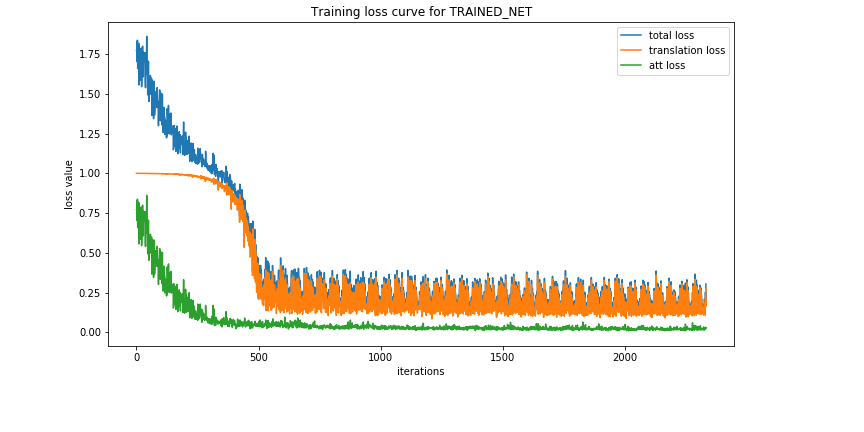

Epoch: 0 Loss: 1.686560887210774, 0.9994737854543722, 0.6870870938840902
Epoch: 1 Loss: 1.4689535082511183, 0.9982287220235141, 0.470724788476836
Epoch: 2 Loss: 1.2981424601572864, 0.9961394330240646, 0.3020030285389918
Epoch: 3 Loss: 1.1953371335875314, 0.991786205543662, 0.20355093704079683
Epoch: 4 Loss: 1.1156068500482812, 0.9826744052599061, 0.13293244900568477
Epoch: 5 Loss: 1.055433086629184, 0.964460182864711, 0.09097290453764628
Epoch: 6 Loss: 0.9922926324718403, 0.926679033153462, 0.06561359875607041
Epoch: 7 Loss: 0.9013971607640104, 0.8458034891002583, 0.05559367595135041
Epoch: 8 Loss: 0.7121526317776374, 0.6580853968296411, 0.054067232277033465
Epoch: 9 Loss: 0.36990990560009795, 0.31986725977006947, 0.05004264484598951
Epoch: 10 Loss: 0.2812379733571466, 0.23153023351475877, 0.04970773949094538
Epoch: 11 Loss: 0.2724645039382971, 0.22511613059718655, 0.04734837270851405
Epoch: 12 Loss: 0.2539571981947377, 0.20675279902962018, 0.047204398040501576
Epoch: 13 Loss: 0.248518

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


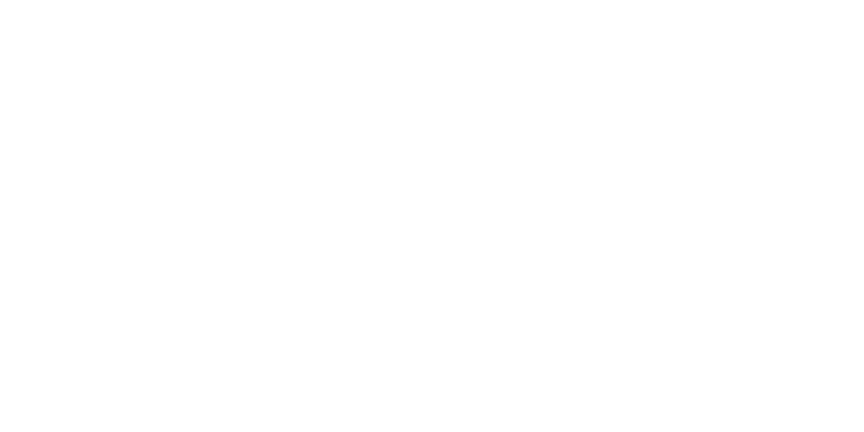

In [34]:
%%time
%matplotlib notebook
if TRAINING:
    EPOCH = 100
    trained_net = MangoNet()
#     trained_net = TangoNet()
    if USE_GPU:
        trained_net = trained_net.cuda()

    # Criterion
    # 1) PoseNetCriterion: does not work :(
    # criterion = PoseNetCriterion(learn_beta=True)
    # 2) Render4CNN Criterion:
#     criterion = SoftmaxVPLoss(kernel_size=3, sigma=30)
#     criterion = SoftmaxVPLoss(kernel_size=3, sigma=3)
#     criterion = SoftmaxVPLoss()

#     if USE_GPU:
#         criterion = criterion.cuda()

    # Add all params for optimization
    # param_list = [{'params': trained_net.parameters()}]
    # if criterion.learn_beta:
    #     # Add sx and sq from loss function to optimizer params
    #     param_list.append({'params': criterion.parameters()})
    
    # Optimizer
    optimizer_t = get_optimizer(trained_net.t_branch, 0.1)
    optimizer_a = get_optimizer(trained_net, 0.001)
#     optimizer_a = torch.optim.Adam(list(trained_net.parameters()), lr = 3e-4)
#     optimizer = torch.optim.SGD(params=param_list,
#                                 lr=0.001,
#                                 weight_decay=0.0001,
#                                 momentum=0.9)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer_t, step_size=10, gamma=0.1)
    
    # Switch to train mode
    trained_net.train()

    print("Starting Training...")

    loss_graph = [[],[],[],[],[]]

    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
    ax = fig.add_subplot(1,1,1)


    for e in range(EPOCH):            
        total_loss, loss_t, loss_att = train(train_loader, trained_net, optimizer_t, optimizer_a, loss_graph)
#         loss = train2(train_loader, trained_net, criterion, optimizer, loss_graph)
#         loss = train3(train_loader, trained_net, criterion, optimizer_a, loss_graph)
#         scheduler.step()
        ax.clear()
        ax.set_xlabel('iterations')
        ax.set_ylabel('loss value')
        ax.set_title('Training loss curve for TRAINED_NET')
        ax.plot(loss_graph[0], label='total loss')
        ax.plot(loss_graph[1], label='translation loss')
        ax.plot(loss_graph[2], label='att loss')
#         ax.plot(loss_graph[3], label='th2 loss')
#         ax.plot(loss_graph[4], label='th3 loss')
        ax.legend(loc='upper right')
        fig.canvas.draw()
        print("Epoch: {} Loss: {}, {}, {}".format(e, total_loss, loss_t, loss_att))
%matplotlib inline

## Testing

In [35]:
def origin_reg_conversion(label, K, t_out):
    u = (label[4:11][0] + label[4:11][2]) / 2.0
    v = (label[4:11][1] + label[4:11][3]) / 2.0
    cx = K[0, 2]
    cy = K[1, 2]
    fx = K[0, 0]
    fy = K[1, 1]
    tx = (u + t_out[0] - cx*t_out[2])/fx
    ty = (v + t_out[1] - cy*t_out[2])/fy
#     tx = t_out[2]/fx*(u + t_out[0]-cx)
#     ty = t_out[2]/fy*(v + t_out[1]-cy)
    return np.array([tx, ty, t_out[2]])


In [36]:
def evaluate(val_loader, net):
    t1_loss = 0
    t2_loss = 0
    t3_loss = 0
    total_loss = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, target, K = data

            if USE_GPU:
                inputs = inputs.cuda()
                target = target.cuda()
                K = K.cuda()

            att_gt = target[:, :4].float()
#             dcm_gt = quat2dcm_batch(att_gt)
#             e_gt = dcm_to_euler321_batch(dcm_gt)
#             e_gt = e_gt.cuda()
            t_gt = target[:, 4:7].float()

#             th1, th2, th3 = net(inputs)
#             L_th1 = criterion(th1, e_gt[:, 0])
#             L_th2 = criterion(th2, e_gt[:, 1])
#             L_th3 = criterion(th3, e_gt[:, 2])
            t, att = net(inputs)
            # t = net(inputs)
            # att = net(inputs)

#             L_t = translation_loss(t_gt, t)
            L_t = translation_loss2(t_gt, t, target[:, 7:11], K)
            L_att = attitude_loss(att_gt, att)
#             t1_loss += L_th1.item()
#             t2_loss += L_th2.item()
#             t3_loss += L_th3.item()

#             loss = L_th1+L_th2+L_th3
            loss = L_t + L_att
            total_loss += loss.item()

    return total_loss / len(val_loader)#, t1_loss / len(val_loader), t2_loss / len(val_loader), t3_loss / len(val_loader)

In [37]:
# Switch to evaluation mode
# TODO: plot test loss
trained_net.eval()
test_loss = evaluate(test_loader, trained_net)
print("Test error: {}".format(test_loss))

Test error: 0.3571509739756584


Translation error: 14.884944306760369
Orientation error: 0.22259607990914576


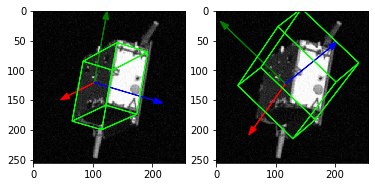

In [41]:
# Evaluation
%matplotlib inline
idx = 83
img1, label1, K1 = test_dataset[idx]

if USE_GPU:
    img1 = img1.cuda()
# t1_out, t2_out, t3_out = trained_net.forward(img1[None])
t_out, att_out = trained_net.forward(img1[None])
t_out = t_out.detach().cpu().numpy()[0]
att_out = att_out.detach().cpu().numpy()[0]
# t1_out = t1_out.detach().cpu().numpy()[0]
# t2_out = t2_out.detach().cpu().numpy()[0]
# t3_out = t3_out.detach().cpu().numpy()[0]
# att_out = dcm_to_q(euler321_to_dcm(np.argmax(t1_out), np.argmax(t2_out), np.argmax(t3_out)))
img1 = img1.cpu()

# Plotting groundtruth
size = (256, 256)
vectorScaleFactor = 4
image1, label1 = JointRescrop((256, 256))(tF.to_pil_image(img1), label1.numpy())

fig = plt.figure()
fig.add_subplot(1, 2, 1)
true_origin = training_dataset.visualize(image1, label1, K1, factor=0.6, bbox=True)

fig.add_subplot(1, 2, 2)

# MRP conversion
# new_att = mrp_to_q(att_out)
# test_dataset.dataset.visualize(image1, np.concatenate((new_att, t_out)), bbox=True)

# Origin regression from bbox center
att_out /= np.linalg.norm(att_out)
t_pred_new = origin_reg_conversion(label1, K1, t_out)
# origin = test_dataset.dataset.visualize(image1, np.concatenate((label1[:4], t_pred_new)), K1, factor=0.6, bbox=True)
origin = test_dataset.dataset.visualize(image1, np.concatenate((att_out, t_pred_new)), K1, factor=0.6, bbox=True)

# Standard
# att_out /= np.linalg.norm(att_out)
# origin = test_dataset.dataset.visualize(image1, np.concatenate((att_out, label1[4:7])), K1, factor=0.6, bbox=True)
# origin = test_dataset.dataset.visualize(image1, np.concatenate((att_out, t_out)), K1, factor=0.6, bbox=True)

# Prediction errors
# Difference in body frame origin (in image plane)
t_error = np.linalg.norm(np.array(true_origin) - np.array(origin))

# Quaternion error
q_error = 1-np.dot(label1[:4], att_out)**2
# plt.title("$t_e = {{{}}}$ \n $q_e = {{{}}}$".format(t_error, q_error))
print("Translation error: {}".format(t_error))
print("Orientation error: {}".format(q_error))